# Neural Data Processing Notebook
### Kyle McGraw, February 2025

A notebook to explore a publicly available dataset on [neural population dynamics during reaching](https://dandiarchive.org/dandiset/000070)

In [134]:
# Imports
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from scipy.signal import butter, filtfilt

## Loading the data

In [2]:
# Load an example file to explore
file_path = "data/000070/sub-Jenkins/sub-Jenkins_ses-20090912_behavior+ecephys.nwb"

# Open the NWB file
io = NWBHDF5IO(file_path, mode='r', load_namespaces=True)
example_data = io.read()

example_data

/Users/kylemcgraw/Documents/neural-data-exploration/venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/kylemcgraw/Documents/neural-data-exploration/venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Data type,float64
Shape,"(4696343, 2)"
Array size,71.66 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(4696343,)"
Array size,35.83 MiB
Chunk shape,None


# Exploring the data

## Behavioral Data

In [3]:
# Get the behavior module
behavior_module = example_data.processing["behavior"]
behavior_module

Data type,float64
Shape,"(4696343, 2)"
Array size,71.66 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(4696343,)"
Array size,35.83 MiB
Chunk shape,None


In [4]:
# Get the position data
position = behavior_module.get("Position")
position

Data type,float64
Shape,"(4696343, 2)"
Array size,71.66 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(4696343,)"
Array size,35.83 MiB
Chunk shape,None


In [5]:
# Get an example spatial series
spatial_series = position.spatial_series["Eye"]
spatial_series

Data type,float64
Shape,"(4696343, 2)"
Array size,71.66 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(4696343,)"
Array size,35.83 MiB
Chunk shape,None


In [6]:
# Take a look at the data and timestamps
eye_data = spatial_series.data
eye_timestamps = spatial_series.timestamps

print(f"Data shape: {eye_data.shape}")
print(f"Timestamps shape: {eye_timestamps.shape}")

Data shape: (4696343, 2)
Timestamps shape: (4696343,)


In [7]:
eye_timestamps[0]

np.float64(64.55126666666666)

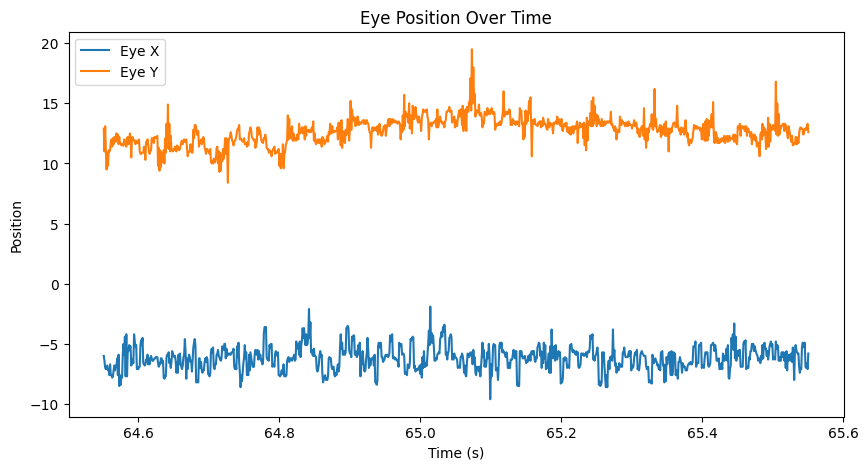

In [8]:
# Plot a portion of the data
plt.figure(figsize=(10, 5))
plt.plot(eye_timestamps[:1000], eye_data[:1000, 0], label="Eye X")
plt.plot(eye_timestamps[:1000], eye_data[:1000, 1], label="Eye Y")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.title("Eye Position Over Time")
plt.legend()
plt.show()

## Electrophysiological Data

In [9]:
# Get the ecephys module
ecephys_module = example_data.processing["ecephys"]
ecephys_module

ecephys pynwb.base.ProcessingModule at 0x5109881248
Fields:
  data_interfaces: {
    Processed <class 'pynwb.ecephys.FilteredEphys'>
  }
  description: Intermediate data from extracellular electrophysiology recordings, e.g., LFP.

In [10]:
# Get the processed data
processed = ecephys_module.get("Processed")
processed

Processed pynwb.ecephys.FilteredEphys at 0x5110023840
Fields:
  electrical_series: {
    A001 <class 'pynwb.ecephys.ElectricalSeries'>,
    A002 <class 'pynwb.ecephys.ElectricalSeries'>,
    B001 <class 'pynwb.ecephys.ElectricalSeries'>,
    B002 <class 'pynwb.ecephys.ElectricalSeries'>
  }

In [11]:
# Get an example electrical series
electrical_series = processed.electrical_series["A001"]
electrical_series

A001 pynwb.ecephys.ElectricalSeries at 0x5109882544
Fields:
  comments: Generated from SpikeInterface::NwbRecordingExtractor
  conversion: 1e-06
  data: <HDF5 dataset "data": shape (7464590, 96), type "<i2">
  description: LFP signal for array A, segment 1data for both arrays A,B in the same segment should be, but is not of the same time lengthand cannot be synced due to lack of time stamps. Ignore the starting times.
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  offset: 0.0
  rate: 1000.0
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: volts

In [12]:
# Get the data and timestamps
a1_data = electrical_series.data

# NOTE: This is not acutally correct as there are not actually timestamps
# TODO: If using this data with other data, ensure timestamps are aligned
a1_timestamps = electrical_series.starting_time + np.arange(a1_data.shape[0]) / electrical_series.rate

print(f"Data shape: {a1_data.shape}")
print(f"Timestamps shape: {a1_timestamps.shape}")

Data shape: (7464590, 96)
Timestamps shape: (7464590,)


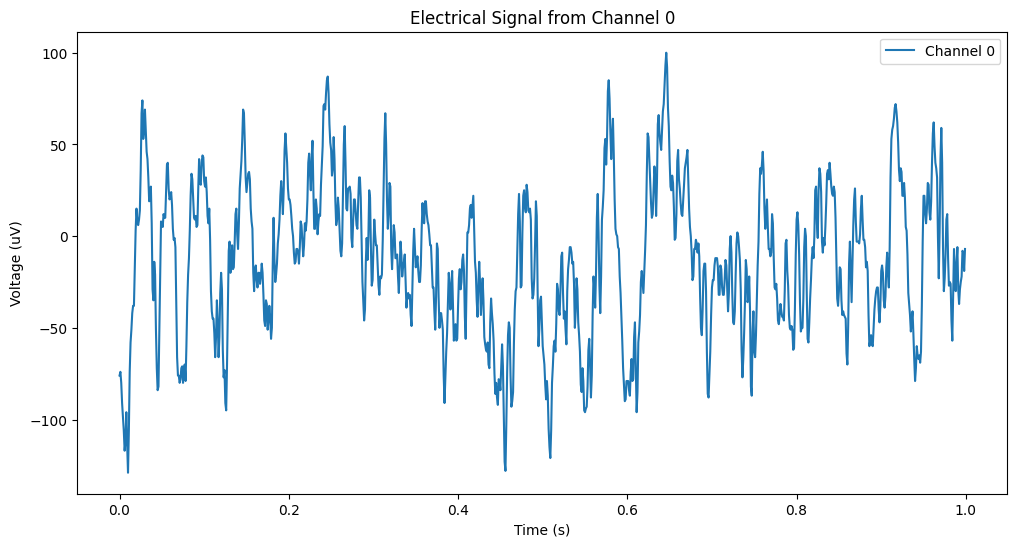

In [13]:
# Plot a portion of the data
plt.figure(figsize=(12, 6))
plt.plot(a1_timestamps[:1000], a1_data[:1000, 0], label="Channel 0")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (uV)")
plt.title("Electrical Signal from Channel 0")
plt.legend()
plt.show()

## Other Data

In [14]:
# Get the trials data
trials_df = example_data.trials.to_dataframe()
trials_df.head()

,start_time,stop_time,target_presentation_time,go_cue_time,reaction_time,move_begins_time,move_ends_time,discard_trial,task_success,trial_type,...,correct_reach,maze_num_targets,maze_num_barriers,novel_maze,target_positions,frame_details,hit_target_position,target_size,barrier_info,timeseries
id,,,,,,,,,,,,,,,,,,,,,
0,64.551267,68.191133,65.485267,66.316267,0.310,66.588267,66.903267,0,1,5,...,1,1,0,0,"[[132, 46]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[132, 46]",13,[],"[(0, 3051, Eye pynwb.behavior.SpatialSeries at..."
1,69.186267,72.581167,70.071267,70.701267,0.325,70.988267,71.293267,0,1,7,...,1,1,0,0,"[[0, 86]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[-9, 86]",13,[],"[(3051, 2806, Eye pynwb.behavior.SpatialSeries..."
2,73.676400,76.861367,74.623400,74.720400,0.365,75.053400,75.478400,0,1,1,...,1,3,6,0,"[[111, 85], [133, 0], [0, 0]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[111, 85]",13,"[[-69.0, -16.0, 69.0, 13.0], [-120.0, -62.0, 1...","[(5857, 2501, Eye pynwb.behavior.SpatialSeries..."
3,78.511533,81.971467,79.292533,80.106533,0.340,80.413533,80.673533,0,1,0,...,0,1,5,1,"[[0, 0]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[-55, -81]",13,"[[141.0, 21.0, 11.0, 41.0], [82.0, 76.0, 40.0,...","[(8358, 2861, Eye pynwb.behavior.SpatialSeries..."
4,82.991300,85.926167,83.677300,84.091300,0.355,84.408300,84.683300,0,1,3,...,1,1,0,0,"[[0, 0]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[-116, -5]",13,[],"[(11219, 2391, Eye pynwb.behavior.SpatialSerie..."


In [15]:
# Get the first trial
first_trial = trials_df.iloc[0]
first_trial

start_time                                                          64.551267
stop_time                                                           68.191133
target_presentation_time                                            65.485267
go_cue_time                                                         66.316267
reaction_time                                                            0.31
move_begins_time                                                    66.588267
move_ends_time                                                      66.903267
discard_trial                                                               0
task_success                                                                1
trial_type                                                                  5
trial_version                                                               0
proto_trial                                                                 0
maze_condition                                                  

In [52]:
# Behavior data linked in trials
first_trial['timeseries'][0], first_trial['timeseries'][0].data.shape

(TimeSeriesReference(idx_start=np.int32(0), count=np.int32(3051), timeseries=Eye pynwb.behavior.SpatialSeries at 0x5109882400
 Fields:
   comments: no comments
   conversion: nan
   data: <HDF5 dataset "data": shape (4696343, 2), type "<f8">
   description: no description
   interval: 1
   offset: 0.0
   reference_frame: screen center
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (4696343,), type "<f8">
   timestamps_unit: seconds
   unit: meters
 ),
 (3051, 2))

In [49]:
# Count discard trial across all trials
discard_counts = trials_df['discard_trial'].value_counts()
print("\nDiscard Counts:")
print(discard_counts)

# Count task success across all trials
task_success_counts = trials_df['task_success'].value_counts()
print("\nTask Success Counts:")
print(task_success_counts)

# Count correct reach across all trials
correct_reach_counts = trials_df['correct_reach'].value_counts()
print("\nCorrect Reach Counts:")
print(correct_reach_counts)

# Count trial type across all trials
trial_type_counts = trials_df['trial_type'].value_counts()
print("\nTrial Type Counts:")
print(trial_type_counts)


Discard Counts:
discard_trial
0    1588
Name: count, dtype: int64

Task Success Counts:
task_success
1    1573
0      15
Name: count, dtype: int64

Correct Reach Counts:
correct_reach
1    1015
0     573
Name: count, dtype: int64

Trial Type Counts:
trial_type
0     184
9     129
2     129
6     128
11    127
8     122
7     115
3     113
1     111
4     110
12    107
10    107
5     106
Name: count, dtype: int64


In [18]:
# Get the electrodes data
electrodes_df = example_data.electrodes.to_dataframe()
electrodes_df.head()

,x,y,z,imp,location,filtering,group,group_name,gain,offset
id,,,,,,,,,,
1,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...,1,1.0,0.0
2,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...,1,1.0,0.0
3,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...,1,1.0,0.0
4,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...,1,1.0,0.0
5,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...,1,1.0,0.0


In [19]:
# Get the units data
units_df = example_data.units.to_dataframe()
units_df.head()

,spike_times,obs_intervals,electrodes,electrode_group
id,,,,
0,"[64.68116666666667, 64.8448, 65.02746666666667...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...
1,"[4469.972166666666, 4469.983066666667, 4470.03...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...
2,"[64.57156666666667, 64.709, 64.73143333333334,...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...
3,"[64.55590000000001, 64.5644, 64.58023333333334...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...
4,"[64.55216666666666, 64.5821, 64.85373333333334...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5110174672...


# Visualizing the data

## Behavioral Data

In [44]:
# Enum for index of each position type in the trials dataframe
class Position(Enum):
    Eye = 0
    Hand = 1 
    Cursor = 2

def plot_behavioral_trial(trial_index: int, position_type: Position):
    """
    Plot the behavioral data for a given trial and position type

    Parameters:
    - trial_index: The index of the trial to plot
    - position_type: The position type to plot
    """
    # Get the trial data
    trial = trials_df.iloc[trial_index]

    # Get the position data
    position_data = trial['timeseries'][position_type.value]
    assert position_data.timeseries.name == position_type.name

    # Get the position data
    position_x = position_data.data[:, 0]
    position_y = position_data.data[:, 1]

    # Get the target positions
    target_positions = trial['target_positions']

    # Plot the position data
    plt.figure(figsize=(8, 8))
    plt.plot(position_x, position_y, color='blue', alpha=0.5)

    # Plot the start and end positions
    plt.scatter(position_x[0], position_y[0], color='red', label="Start Position", zorder=3)
    plt.scatter(position_x[-1], position_y[-1], color='green', label="End Position", zorder=3)

    # Plot the target positions
    for i, target_position in enumerate(target_positions):
        plt.scatter(target_position[0], target_position[1], color='yellow', label=f"Target Position {i}", zorder=3)

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title(f"{position_type.name} Trajectory During Reaching: Trial {trial_index}")
    plt.legend()
    plt.show()

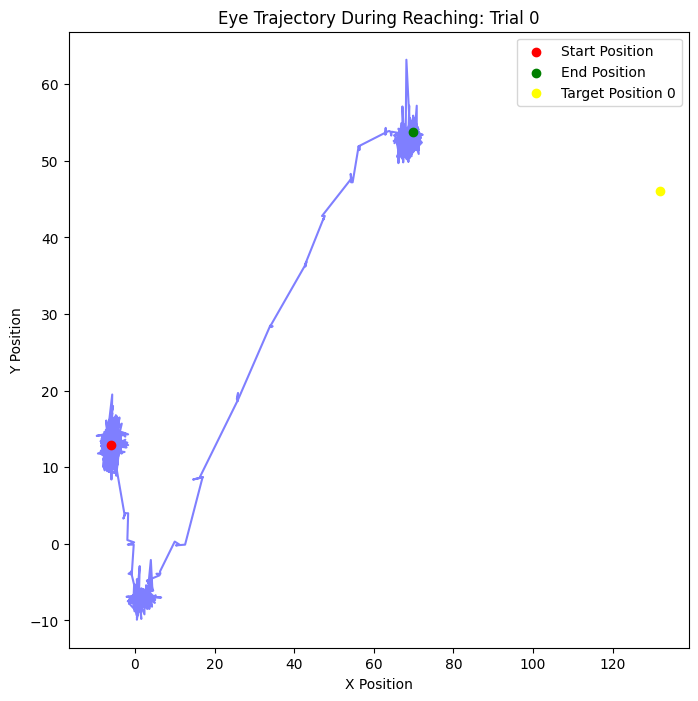

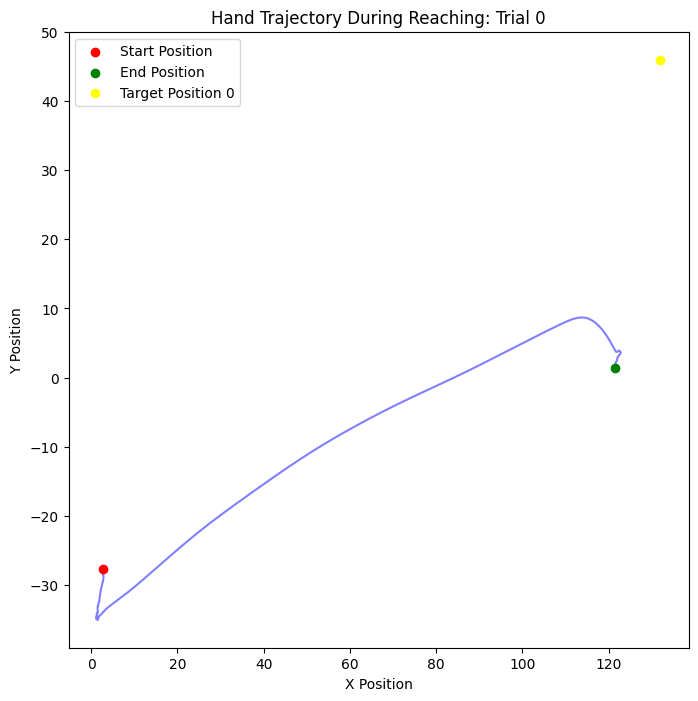

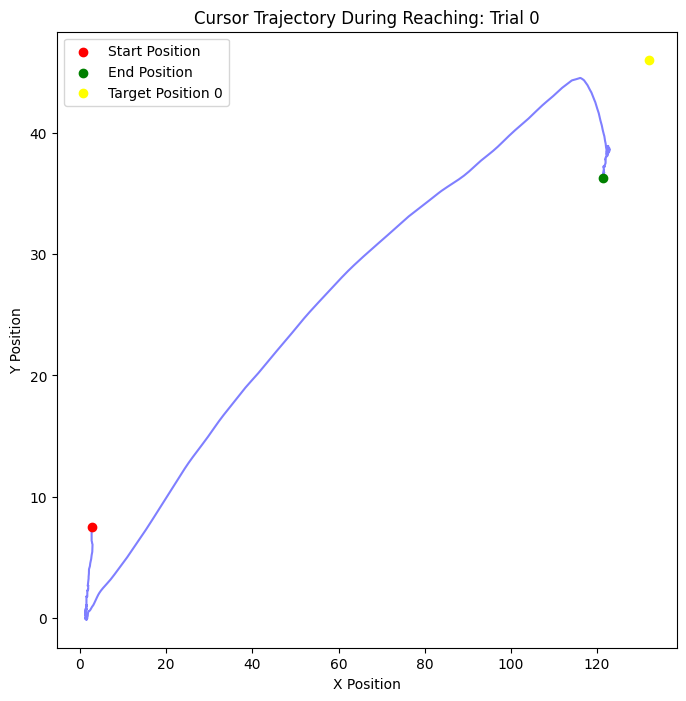

In [48]:
trial_index = 0
plot_behavioral_trial(trial_index, Position.Eye)
plot_behavioral_trial(trial_index, Position.Hand)
plot_behavioral_trial(trial_index, Position.Cursor)

## Electrophysiological Data

### Spike Data

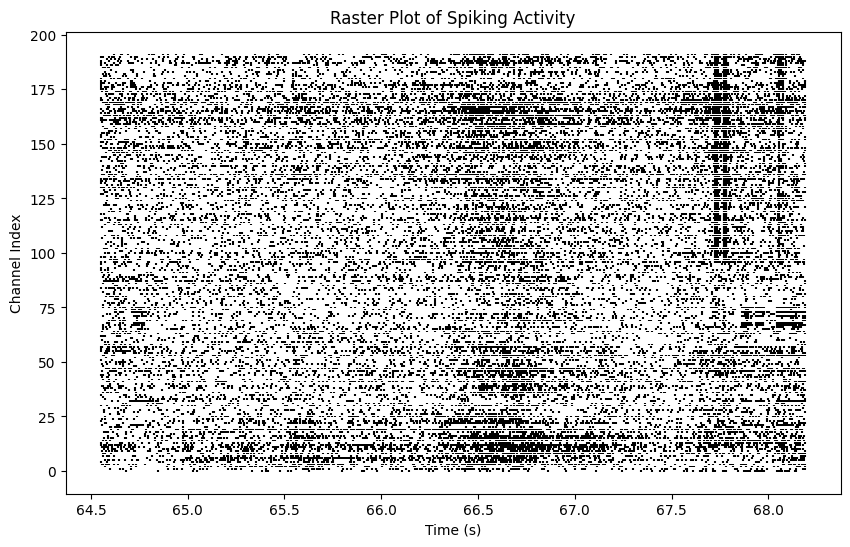

In [67]:
trial_index = 0

plt.figure(figsize=(10, 6))

# Get the spike times
for i in range(len(units_df)):
    unit = units_df.iloc[i]
    spike_times = unit['spike_times']

    # Get spikes for trial
    trial_interval = unit['obs_intervals'][trial_index]
    aligned_spikes = []
    aligned_spikes.extend(spike_times[(spike_times >= trial_interval[0]) & (spike_times <= trial_interval[1])])
    
    plt.eventplot(aligned_spikes, lineoffsets=i, linelengths=0.8, color='black')

plt.xlabel("Time (s)")
plt.ylabel("Channel Index")
plt.title("Raster Plot of Spiking Activity")
plt.show()

In [85]:
def plot_psth(spike_times, trial_intervals, event_times, title="Peri-Stimulus Time Histogram (PSTH)", window=(-0.5, 1.0), bin_size=0.05):
    """
    Plot the peri-stimulus time histogram (PSTH) of the spike times

    Parameters:
    - spike_times: The spike times to plot
    - trial_intervals: The trial intervals to plot
    - event_times: The event times to align the spikes to
    """
    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    histograms = np.zeros((len(spike_times), len(bins) - 1))

    assert len(trial_intervals) == len(event_times)
    for trial_interval, event_time in zip(trial_intervals, event_times):
        aligned_spikes = []
        aligned_spikes.extend(spike_times[(spike_times >= trial_interval[0]) & (spike_times <= trial_interval[1])] - event_time)
        histograms[i] += np.histogram(aligned_spikes, bins=bins)[0]

    # Average across neurons
    mean_psth = histograms.mean(axis=0) / len(event_times) / bin_size  # Convert to firing rate (Hz)

    plt.figure(figsize=(8, 4))
    plt.bar(bins[:-1], mean_psth, width=0.05, color='black')
    plt.xlabel("Time from Event (s)")
    plt.ylabel("Firing Rate (Hz)")
    plt.title(title)
    plt.show()

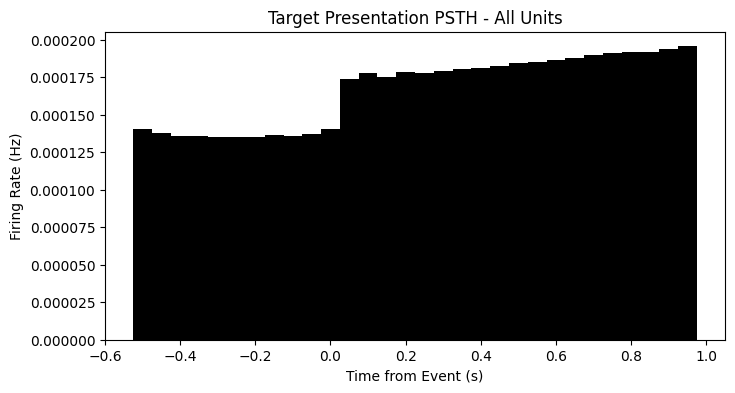

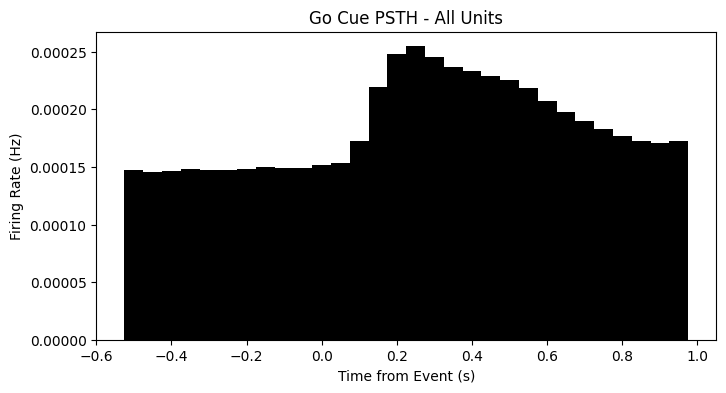

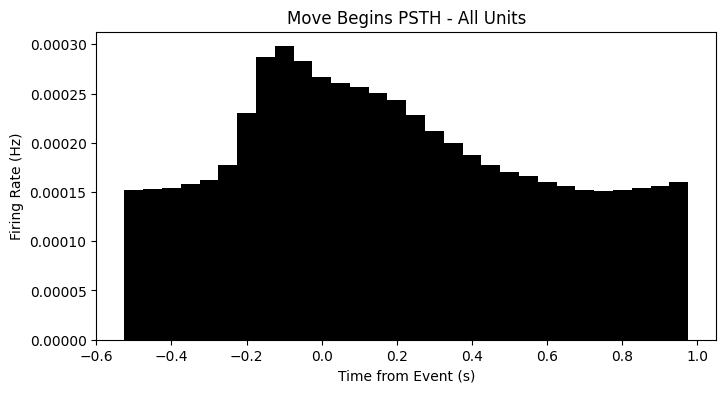

In [86]:
# Plot the PSTH for the target presentation, go cue, and move begins
# Use all spike times from all units
all_spike_times = np.concatenate(units_df['spike_times'].to_numpy())
trial_intervals = units_df['obs_intervals'][0]

target_presentation_times = example_data.trials["target_presentation_time"]
go_cue_times = example_data.trials["go_cue_time"]
move_begins_times = example_data.trials["move_begins_time"]

plot_psth(all_spike_times, trial_intervals, target_presentation_times, title="Target Presentation PSTH - All Units")
plot_psth(all_spike_times, trial_intervals, go_cue_times, title="Go Cue PSTH - All Units")
plot_psth(all_spike_times, trial_intervals, move_begins_times, title="Move Begins PSTH - All Units")

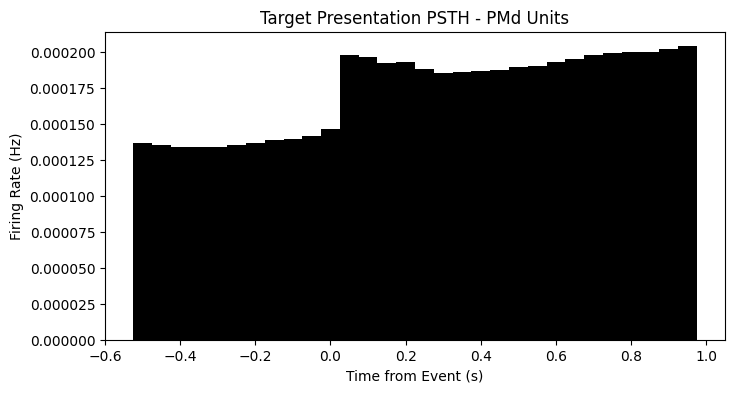

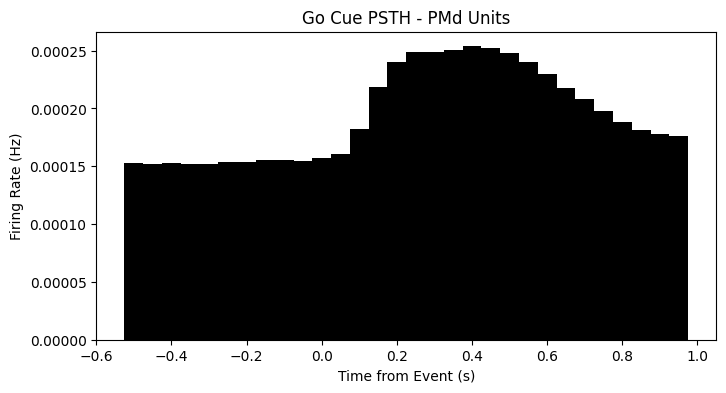

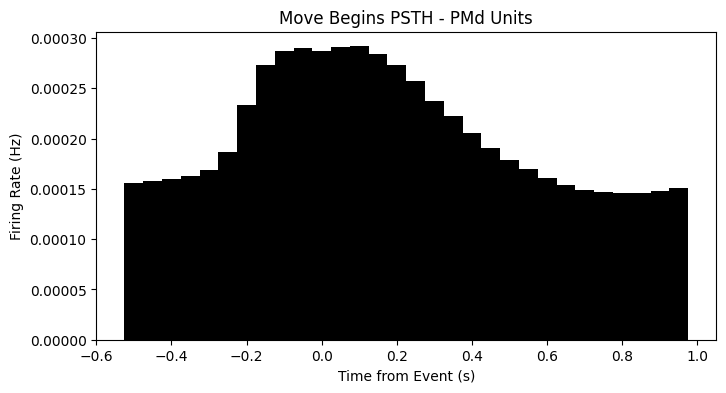

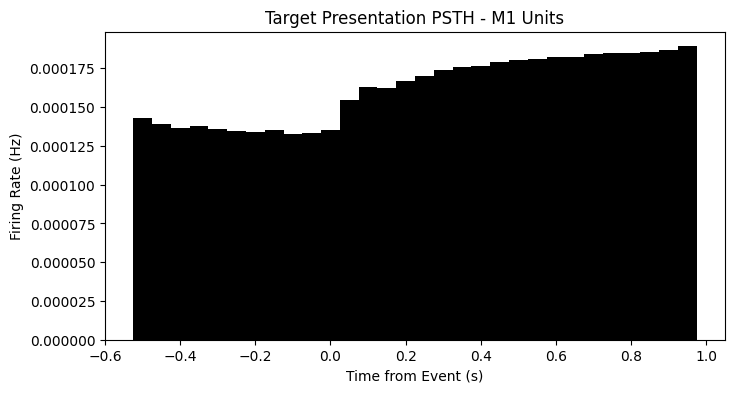

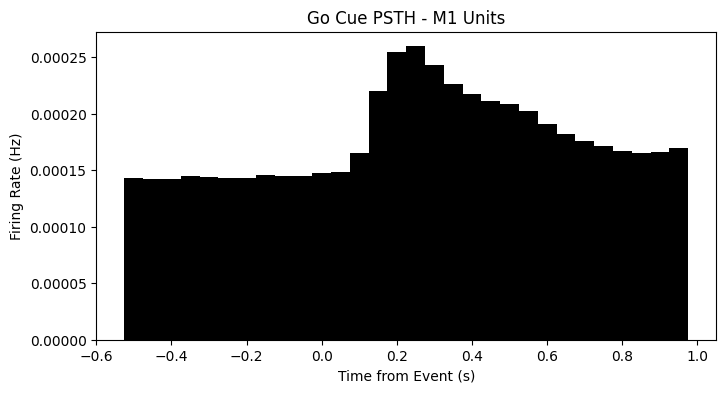

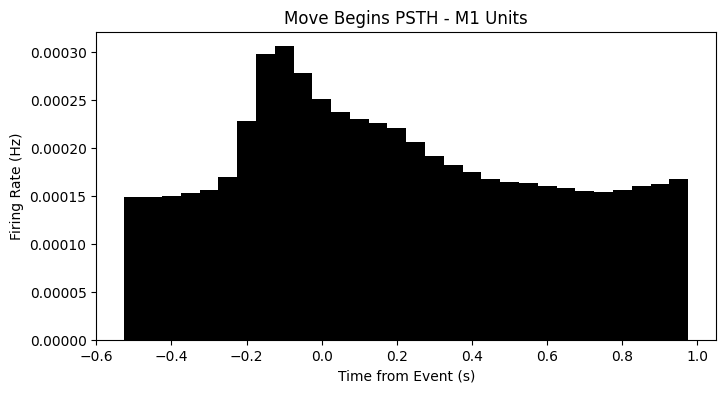

In [131]:
# Plot the PSTH for the target presentation, go cue, and move begins
# Seperate by electrode group
PMd_units = units_df[:int(len(units_df)/2)]
assert all(PMd_units['electrode_group'] == PMd_units['electrode_group'].iloc[0])
PMd_spike_times = np.concatenate(PMd_units['spike_times'].to_numpy())

trial_intervals = units_df['obs_intervals'][0]

target_presentation_times = example_data.trials["target_presentation_time"]
go_cue_times = example_data.trials["go_cue_time"]
move_begins_times = example_data.trials["move_begins_time"]

plot_psth(PMd_spike_times, trial_intervals, target_presentation_times, title=f"Target Presentation PSTH - PMd Units")
plot_psth(PMd_spike_times, trial_intervals, go_cue_times, title=f"Go Cue PSTH - PMd Units")
plot_psth(PMd_spike_times, trial_intervals, move_begins_times, title=f"Move Begins PSTH - PMd Units")

M1_units = units_df[int(len(units_df)/2):]
assert all(M1_units['electrode_group'] == M1_units['electrode_group'].iloc[0])
M1_spike_times = np.concatenate(M1_units['spike_times'].to_numpy())

plot_psth(M1_spike_times, trial_intervals, target_presentation_times, title=f"Target Presentation PSTH - M1 Units")
plot_psth(M1_spike_times, trial_intervals, go_cue_times, title=f"Go Cue PSTH - M1 Units")
plot_psth(M1_spike_times, trial_intervals, move_begins_times, title=f"Move Begins PSTH - M1 Units")


# Signal processing

In [135]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [ ]:
fs = 1000  # Sampling rate (in Hz)
raw_data = 

# Filter the data for beta/gamma frequencies (13-30 Hz)
beta_filtered_data = bandpass_filter(raw_data, 13, 30, fs)
gamma_filtered_data = bandpass_filter(raw_data, 30, 100, fs)

# Plot the original and filtered data
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(raw_data[:5000])
plt.title("Raw Neural Data")

plt.subplot(2, 1, 2)
plt.plot(beta_filtered_data[:5000])
plt.title("Beta Band Filtered Data (13-30 Hz)")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d

def compute_firing_rate(spike_times, window_size=0.1):
    spike_counts = np.histogram(spike_times, bins=np.arange(0, len(spike_times) + window_size, window_size))[0]
    return gaussian_filter1d(spike_counts, sigma=2) / window_size


# Decoding

## Reaching Direction Decoding

In [ ]:
from sklearn.linear_model import LinearRegression

def decode_movement(spike_rates, hand_positions):
    """
    Train a linear decoder to predict hand position from spike rates.

    Parameters:
    - spike_rates: Array of neurons x time points
    - hand_positions: Array of hand positions (X, Y) x time points
    
    Returns:
    - decoder: Trained regression model
    """
    decoder = LinearRegression()
    decoder.fit(spike_rates.T, hand_positions.T)  # Time x neurons → Time x position
    return decoder

# Example usage
decoder = decode_movement(firing_rate_matrix, hand_position_matrix)
